# Part III: Model Training for Left Right Fingerprints

This tutorial is based on the [TensorFlow Image Classification](https://www.tensorflow.org/tutorials/images/classification) with some modifications, which shows how to classify images of fingerprints using a tf.keras.Sequential model and load data using tf.keras.utils.image_dataset_from_directory. 

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
1. Build an input pipeline
1. Build the model
1. Train the model
1. Test the model
1. Improve the model and repeat the process

The workflow above spans multiple notebooks
1. data exploration
1. data preprocessing 
1. model training
1. model tuning

## Setup

Import TensorFlow and other necessary libraries:

In [1]:
! pip install -r ../requirements.txt -q

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import os
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from IPython.display import clear_output

2023-11-20 21:05:30.060429: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-20 21:05:30.060477: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-20 21:05:30.060507: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-20 21:05:30.069547: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 21:05:31.187264: W tensorflow/compiler/

## Check TF and Cuda versions

For reference [see this chart](https://www.tensorflow.org/install/source#gpu)

In [3]:
# check versions for Tensorflow and Cuda
print('TensorFlow: ' + tf.__version__)
print('TensorFlow Datasets: ' + tfds.__version__)
print('OpenCV version: ' + cv2.__version__)

# Check CUDA Version
sys_details = tf.sysconfig.get_build_info()
cuda_version = sys_details["cuda_version"]
print('Cuda version: ' + cuda_version)

# Check CUDNN Version
cudnn_version = sys_details["cudnn_version"]  
print('cudnn version: ' + cudnn_version)

TensorFlow: 2.14.0
TensorFlow Datasets: 4.9.3
OpenCV version: 4.8.1
Cuda version: 11.8
cudnn version: 8


In [4]:
# scratch directory is apart of the .gitignore to ensure it is not committed to git
%env SCRATCH=../scratch
! [ -e "${SCRATCH}" ] || mkdir -p "${SCRATCH}"

scratch_path = os.environ.get('SCRATCH', './scratch')

env: SCRATCH=../scratch


# Create dataset

Define some parameters for the loader

In [5]:
batch_size = 32
img_height = 96
img_width = 96

## Create the training dataset

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  scratch_path + '/processed/hand',
  #color_mode="grayscale",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 17953 files belonging to 2 classes.
Using 14363 files for training.


2023-11-20 21:05:34.409371: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 21:05:34.409769: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 21:05:34.410106: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Create the validation dataset

In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  scratch_path + '/processed/hand',
  #color_mode="grayscale",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 17953 files belonging to 2 classes.
Using 3590 files for validation.


## Print the inferred class names

You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [8]:
class_names = train_ds.class_names
print(class_names)

['left', 'right']


## Visualize the data

Here are the first nine images from the training dataset with their corresponding labels.

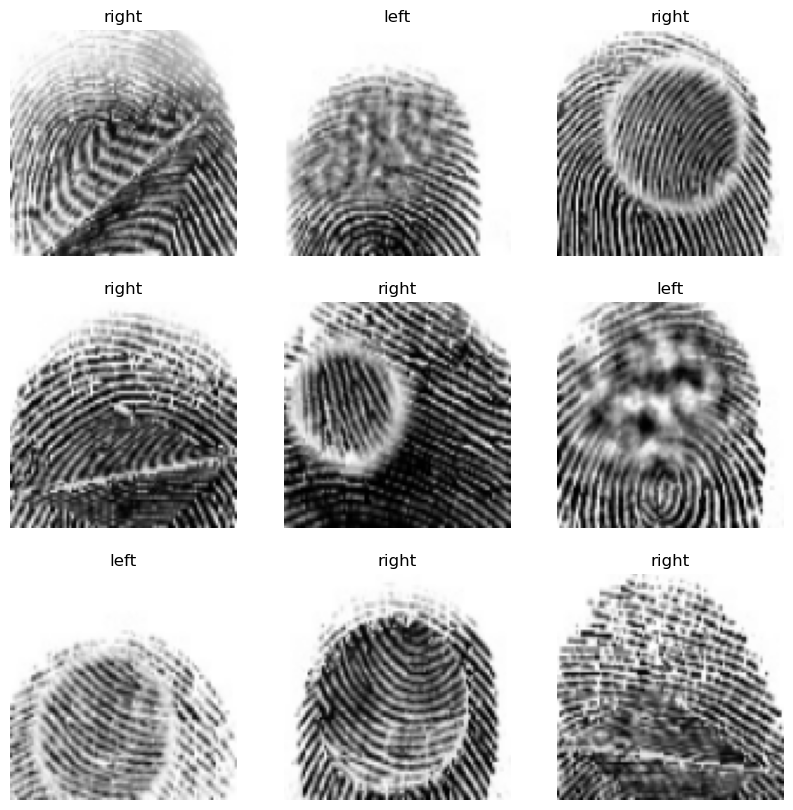

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Pass the datasets to the Keras Model.fit method for training in later steps.

Use the image_batch tensor of  shape (32, 96, 96, 3), which splits batch of 32 images of shape 96x96x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 96, 96, 3)
(32,)


## Configure the dataset for performance

We can use buffered prefetching, to yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

1. `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
1. `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [13]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 4


In [14]:
# cuda_malloc_async has fewer fragmentation issues than the default BFC memory allocator - https://docs.nvidia.com/deeplearning/frameworks/tensorflow-user-guide/index.html#tf_gpu_allocator
TF_FORCE_GPU_ALLOW_GROWTH=True

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
print(os.getenv("TF_GPU_ALLOCATOR"))

cuda_malloc_async


In [15]:
num_classes = len(class_names)
input_image_shape = (96, 96, 1)

with strategy.scope():
    model = Sequential([
      layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3), name="model"),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes)
    ])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Conv2D)              (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 16)        0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 64)        0

In [18]:
epochs=10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
INFO:tensorflow:Collective all_reduce tensors: 10 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 10 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/r

2023-11-20 21:05:46.088693: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-20 21:05:46.106526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-20 21:05:46.126125: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-20 21:05:46.146480: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-20 21:05:48.117526: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7eebf18f35b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-20 21:05:48.117576: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2023-11-20 21:05:48.117591: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla V100-SXM2-16GB, Compute Capability 7.0
2023-11-20 21:05:48.117600: I t

446/449 [============================>.] - ETA: 0s - loss: 2.6423 - accuracy: 0.6774INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
449/449 [==============================] - 14s 13ms/step - loss: 2.6282 - accuracy: 0.6777 - val_loss: 0.5172 - val_accuracy: 0.7412
Epoch 2/10
449/449 [==============================] - 5s 10ms/step - loss: 0.4672 - accuracy: 0.7743 - val_loss: 0.4518 - val_accuracy: 0.7953
Epoch 3/10
449/449 [==============================] - 5s 10ms/step - loss: 0.4306 - accuracy: 0.7946 - val_loss: 0.3903 - val_accuracy: 0.8214
Epoch 4/10
449/449 [==============================] - 5s 10ms/step - loss: 0.3671 - accuracy: 0.8328 - val_loss: 0.3957 - val_accuracy: 0.8242
Epoch 5/10
449/449 [==============================] - 5s 10ms/step - loss:

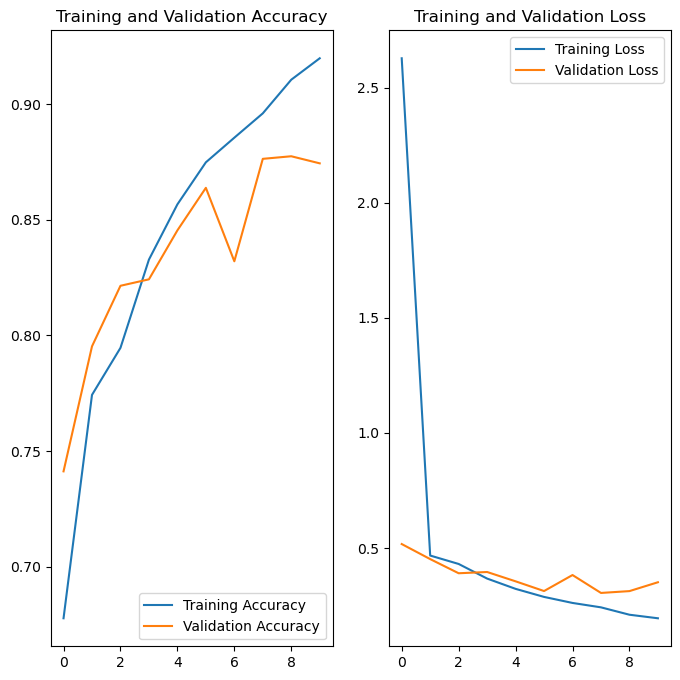

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Serialize Model

In [20]:
# note: tf.saved_model.save(model, path_to_dir)
model_version = os.environ.get('VERSION', "1")


model_path = "../models/hand/" + model_version + "/model.savedmodel"
model.save(model_path)

INFO:tensorflow:Assets written to: ../models/hand/1/model.savedmodel/assets


INFO:tensorflow:Assets written to: ../models/hand/1/model.savedmodel/assets


# Test with a sample

In [21]:
fingerprint = scratch_path + "/real/1__M_Left_index_finger.png"

img = tf.keras.utils.load_img(
    fingerprint, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 1s 973ms/step
This image most likely belongs to left with a 100.00 percent confidence.


In [22]:
model_path = "../models/hand/" + model_version + "/model.savedmodel"
model = keras.models.load_model(model_path)

In [23]:
input_directory = scratch_path + "/real/"  # Replace with the path to your input directory
output_directory = scratch_path + "/processed/real/"  # Replace with the path to your output directory

In [24]:
%run ../src/process_images.py

In [25]:
process_images_in_directory(input_directory, output_directory)

clear_output()

Files in path: 6000
Selected: 152__M_Left_ring_finger.png
shape: (1, 96, 96, 3)


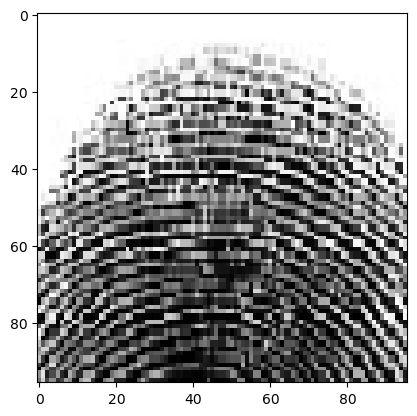

In [26]:
# select random images
import random
import matplotlib.pyplot as plt

samples_path = output_directory
file_list = os.listdir(samples_path)
print('Files in path: ' + str(len(file_list)))

test_image = random.choice(file_list)
print('Selected: ' + test_image)

# loads an image into PIL format.
img = tf.keras.utils.load_img(
    samples_path + test_image,
    #color_mode="grayscale",
    target_size=(img_height, img_width),
    #interpolation='nearest',
)

plt.imshow(img, cmap='gray')

# converts a PIL image instance to a numpy array
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
print("shape:",img_array.shape)

In [27]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image " + test_image + " is predicted as {} with a {:.2f} percent confidence. Prediction is " 
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

class_names[np.argmax(score)] in test_image.lower()

1/1 [==============================] - 0s 87ms/step
This image 152__M_Left_ring_finger.png is predicted as left with a 57.78 percent confidence. Prediction is 


True

# Upload to S3

## List the available buckets

In [28]:
# list objects using the aws s3 cli
! aws s3 ls

2023-11-20 20:24:58 managed-velero-backups-736247ed-2c46-4068-825b-be42f54d5ac3
2023-11-16 22:36:17 rosa-n6wkj-cjkpb-image-registry-us-east-2-wbgvottmvhgatruvbiyd
2023-11-18 14:58:53 sagemaker-fingerprint-data-n6wkj


## List the dynamically created bucket for the demo

In [30]:
import boto3

s3_client = boto3.client('s3')
response = s3_client.list_buckets()

filtered_buckets=[]

for bucket in response['Buckets']:
    bucket_name = bucket['Name']
    if bucket_name.startswith('sagemaker-fingerprint-'):
        filtered_buckets.append(bucket_name)
    
print(filtered_buckets)

['sagemaker-fingerprint-data-n6wkj']


## Upload the model to the demo bucket

In [32]:
import subprocess

for bucket in filtered_buckets:
    command = f"aws s3 sync ../models/hand s3://{bucket}/models/hand"
    subprocess.run(command, shell=True)

upload: ../models/hand/1/model.savedmodel/keras_metadata.pb to s3://sagemaker-fingerprint-data-n6wkj/models/hand/1/model.savedmodel/keras_metadata.pb
upload: ../models/hand/1/model.savedmodel/variables/variables.index to s3://sagemaker-fingerprint-data-n6wkj/models/hand/1/model.savedmodel/variables/variables.index
upload: ../models/hand/1/model.savedmodel/saved_model.pb to s3://sagemaker-fingerprint-data-n6wkj/models/hand/1/model.savedmodel/saved_model.pb
upload: ../models/hand/1/model.savedmodel/fingerprint.pb to s3://sagemaker-fingerprint-data-n6wkj/models/hand/1/model.savedmodel/fingerprint.pb
upload: ../models/hand/1/model.savedmodel/variables/variables.data-00000-of-00001 to s3://sagemaker-fingerprint-data-n6wkj/models/hand/1/model.savedmodel/variables/variables.data-00000-of-00001
